In [4]:
from utils import *
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from datasets import SRDataset
from easydict import EasyDict as edict

In [5]:
# Data parameters
csv_folder = './SRDataset'  # folder with CSV data files
test_data_names = ["Set5", "Set14", "B100", "Urban100", "valid"]
HR_data_folders = ['./SRDataset/benchmark/Set5/HR',
                  './SRDataset/benchmark/Set14/HR',
                  './SRDataset/benchmark/B100/HR',
                  './SRDataset/benchmark/Urban100/HR',
                  './SRDataset/div2k/DIV2K_valid_HR']
LR_data_folders = ['./SRDataset/benchmark/Set5/LR_bicubic/X4',
                  './SRDataset/benchmark/Set14/LR_bicubic/X4',
                  './SRDataset/benchmark/B100/LR_bicubic/X4',
                  './SRDataset/benchmark/Urban100/LR_bicubic/X4',
                  './SRDataset/div2k/DIV2K_valid_LR_bicubic/X4']
srgan_checkpoint = "./output/1/checkpoint_srgan.200.pth.tar"
scaling_factor = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
srgan_generator = torch.load(srgan_checkpoint)['generator'].to(device)
srgan_generator.eval()
model = srgan_generator

In [7]:
# Evaluate
for i in range(len(test_data_names)):
    print("\nFor %s:\n" % test_data_names[i])
    # Custom dataloader
    config = edict()
    config.csv_folder = csv_folder
    config.HR_data_folder = HR_data_folders[i]
    config.LR_data_folder = LR_data_folders[i]
    config.crop_size = 0
    config.scaling_factor = scaling_factor
    test_dataset = SRDataset(split=test_data_names[i], config=config)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=4,
                                              pin_memory=True)
    PSNRs = AverageMeter()
    SSIMs = AverageMeter()
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(test_loader):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            lr_imgs = convert_image(lr_imgs, source='[0, 1]', target='imagenet-norm', device=device)
            hr_imgs = convert_image(hr_imgs, source='[0, 1]', target='[-1, 1]', device=device)
            
            sr_imgs = model(lr_imgs)
            
            sr_imgs_y = convert_image(sr_imgs, source='[-1, 1]', target='y-channel', device=device).squeeze(0)
            hr_imgs_y = convert_image(hr_imgs, source='[-1, 1]', target='y-channel', device=device).squeeze(0)
            psnr = peak_signal_noise_ratio(hr_imgs_y.cpu().numpy(), sr_imgs_y.cpu().numpy(), data_range=255.)
            ssim = structural_similarity(hr_imgs_y.cpu().numpy(), sr_imgs_y.cpu().numpy(), data_range=255.)
            PSNRs.update(psnr, lr_imgs.size(0))
            SSIMs.update(ssim, lr_imgs.size(0))
            
    # Print average PSNR and SSIM
    print('PSNR - {psnrs.avg:.3f}'.format(psnrs=PSNRs))
    print('SSIM - {ssims.avg:.3f}'.format(ssims=SSIMs))

print("\n")


For Set5:

PSNR - 26.244
SSIM - 0.834

For Set14:

PSNR - 24.698
SSIM - 0.728

For B100:

PSNR - 24.630
SSIM - 0.688

For Urban100:

PSNR - 22.613
SSIM - 0.703

For valid:

PSNR - 25.473
SSIM - 0.776




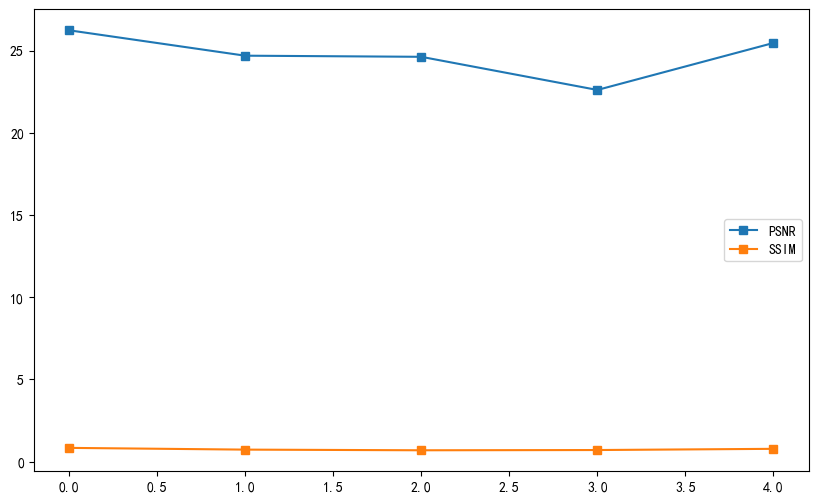

In [9]:
import matplotlib.pyplot as plt

#数据来源：参见上面的运行结果
psnr = [26.244, 24.698, 24.630, 22.613, 25.473]
ssim = [0.834, 0.728, 0.688, 0.703, 0.776]

plt.rcParams['font.sans-serif']=['SimHei']
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
ax.plot(range(5), psnr, marker='s', label ='PSNR')
ax.plot(range(5), ssim, marker='s', label ='SSIM')
# ax.axvline(12,0,1, linestyle='--', c='g')
# plt.xlabel('epoch', fontsize=16)
# plt.xticks(fontsize=12)
# plt.ylabel('loss', fontsize=16)
# plt.yticks(fontsize=12)
plt.legend()
plt.show()